In [223]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import datetime
from datetime import datetime, date

In [155]:
# Настройка вывода данных
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

## Подготовка данных.
### Сбор сырых(исходных) данных.

In [156]:
df_f = pd.read_excel("d.xlsx", sheet_name='Лист1')
# df_f

### Подготовка данных

In [157]:
# Удаление лишних столбцов и колонок
df_clear = df_f.drop(index=[0, 1, 269, 270, 271], columns='Unnamed: 3389').reset_index().drop(columns='index')

In [158]:
# Транспонирование таблицы из строк в столбцы
df_test = df_clear.transpose().reset_index(drop=True)
# df_test

In [159]:
# Применение к строке из списка роли имен колонок.
df_test.columns = df_test.iloc[0]

fragment_01 = df_test.reindex(df_test.index.drop(1)).drop(index=0)
fragment_01 = fragment_01.rename(columns={"Названия строк": 'Дата'}).reset_index(drop=True)
fragment_01.columns.name = 'ID'

In [160]:
# Получить все имена колонок.
fragment_01.columns.tolist()[:5]

['Дата',
 '01. Ноутбуки',
 '01. Нетбуки',
 '02. Ноутбуки',
 '03. Аксессуары для ноутбуков']

In [161]:
# Удаление ненужных колонок
fragment_01 = fragment_01.drop(columns=[
    '01. Ноутбуки',
    '02. Компьютеры',
    'EOL/Не используется',
    '03. Комплектующие',
    '04. Мониторы',
    '05. Сотовые, планшеты и электронные книги',
    '06. Камеры цифровые',
    '07. Карманные гаджеты',
    '08. ТВ и медиа',
    '09. Акустика',
    '10. Кабельная продукция',
    '11. Печатающая офисная техника/Оргтехника',
    '13. Источники бесперебойного питания',
    '14. Мелочи и аксессуары',
    '16. Чехлы и сумки',
    '17. Расходники и накопители информации',
    '18. Бытовая техника',
    '19. Автоэлектроника',
    '20. Интертеймент',
    '21. Сетевое Оборудование',
    '22. Источники питания',
    '23. Сумки',
    '26. Инструменты'
])

In [192]:
# Общее кол-во пропущенных элементов
fragment_01.isnull().sum().sum()

0

In [193]:
# Приведение типа "datetime64" к колонке.
fragment_01['Дата'] = pd.to_datetime(fragment_01['Дата'], format='%Y-%m-%d')
fragment_01 = fragment_01.fillna(0)

In [281]:
# Вынос Мясяца и Года в отдельную колонку.
fragment_01['День'] = fragment_01['Дата'].dt.day
fragment_01['Месяц'] = fragment_01['Дата'].dt.month
fragment_01['Год'] = fragment_01['Дата'].dt.year
fragment_01

ID,Дата,01. Нетбуки,02. Ноутбуки,03. Аксессуары для ноутбуков,ГСБ,...,Цепные пилы,Шуруповерты,Месяц,Год,День
0,2011-09-05,0.0,0.0,0.0,0.0,...,0,0.0,9,2011,5
1,2011-09-06,0.0,65797.0,0.0,0.0,...,0,0.0,9,2011,6
2,2011-09-07,0.0,86395.0,0.0,6650.0,...,0,0.0,9,2011,7
3,2011-09-08,27954.0,48279.0,0.0,0.0,...,0,0.0,9,2011,8
4,2011-09-09,0.0,56004.0,0.0,0.0,...,0,0.0,9,2011,9
...,...,...,...,...,...,...,...,...,...,...,...
3382,2020-12-15,0.0,362697.0,-2499.0,51998.0,...,0,0.0,12,2020,15
3383,2020-12-16,0.0,380990.0,0.0,0.0,...,0,0.0,12,2020,16
3384,2020-12-17,0.0,134997.0,2150.0,45048.0,...,0,2250.0,12,2020,17
3385,2020-12-18,0.0,181446.0,0.0,55198.0,...,0,0.0,12,2020,18


In [271]:
fragment_01.columns.tolist()[:10]

['Дата',
 '01. Нетбуки',
 '02. Ноутбуки',
 '03. Аксессуары для ноутбуков',
 'ГСБ',
 'Моноблоки',
 'Неттопы',
 'Платформы для мини ПК',
 'Блоки питания',
 'Видеокарты']

In [285]:
name = '02. Ноутбуки'

In [290]:
group = fragment_01[['Дата', f'{name}']].loc[(fragment_01['Год'] == 2020)&(fragment_01['Месяц'] == 6)].groupby(fragment_01['День']).sum()
group = group.reset_index()

group

ID,День,02. Ноутбуки
0,1,182415.00
1,2,0.00
2,3,315189.00
3,4,174396.00
4,5,215695.00
...,...,...
25,26,202197.08
26,27,244626.10
27,28,114097.00
28,29,55998.00


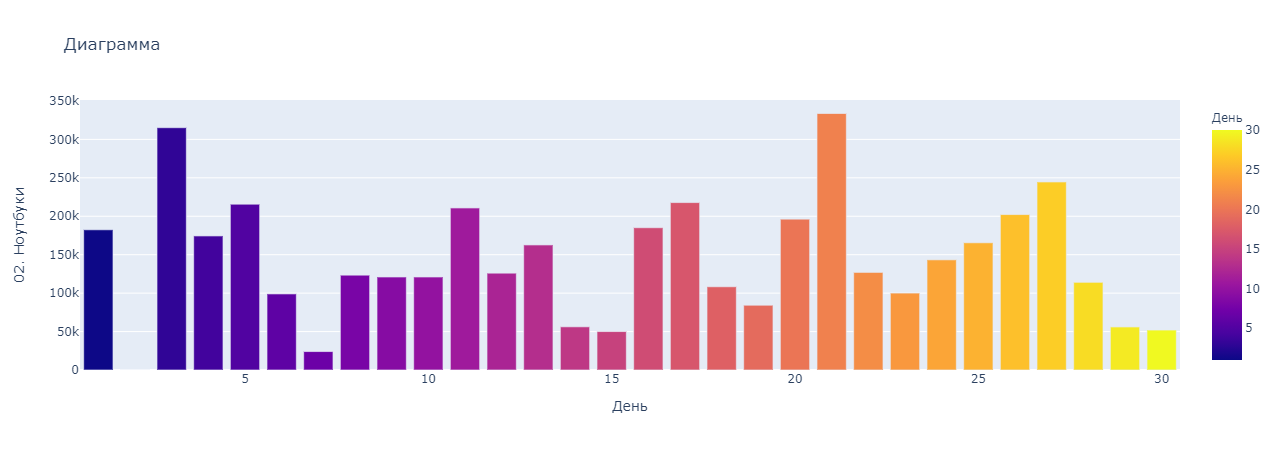

In [291]:
fig = px.bar(group, 
             x="День", 
             y="02. Ноутбуки", 
             color="День", 
             title="Диаграмма")
fig.show()

In [275]:
data = fragment_01['Дата'].dt.year.unique()[-4:].tolist()
data

[2017, 2018, 2019, 2020]

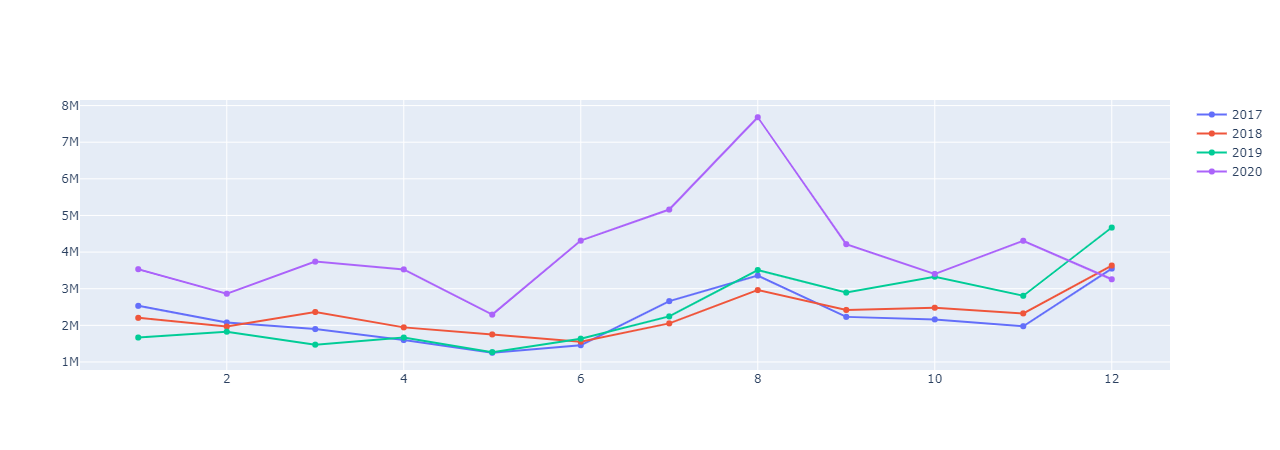

In [276]:
# выборка по конкретной группе общей суммы по месяцам.

fig = go.Figure()

for i in data:
    group = fragment_01[['Дата', f'{name}']].loc[fragment_01['Год'] == i].groupby(fragment_01['Месяц']).sum()
    group = group.reset_index()
    
    fig.add_trace(go.Scatter(x=group["Месяц"], y=group[name], name=f'{i}'))
    
fig.show()